# Image Classification From Scratch

This notebook is a follow along of the [Image Classification From Scratch](https://keras.io/examples/vision/image_classification_from_scratch/) tutorial from the Keras documentation. The tutorial demonstrates how to train a simple convnet on the Fashion MNIST dataset. The goal is to familiarize myself with the Keras API and the basics of image classification.

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [ ]:
!unzip -q kagglecatsanddogs_5340.zip


In [2]:
!ls

 CDLA-Permissive-2.0.pdf		   PetImages
 Image_Classification_From_Scratch.ipynb  'readme[1].txt'
 kagglecatsanddogs_5340.zip


In [3]:
!ls PetImages

Cat  Dog


## Filter out the corrput images

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")


Deleted 0 images.


## Generate a dataset : 

In [5]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2024-11-11 21:43:42.143463: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Visualize the data

let's try and use plt.imshow to look at some of our images in the training dataset

2024-11-11 21:52:35.081492: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


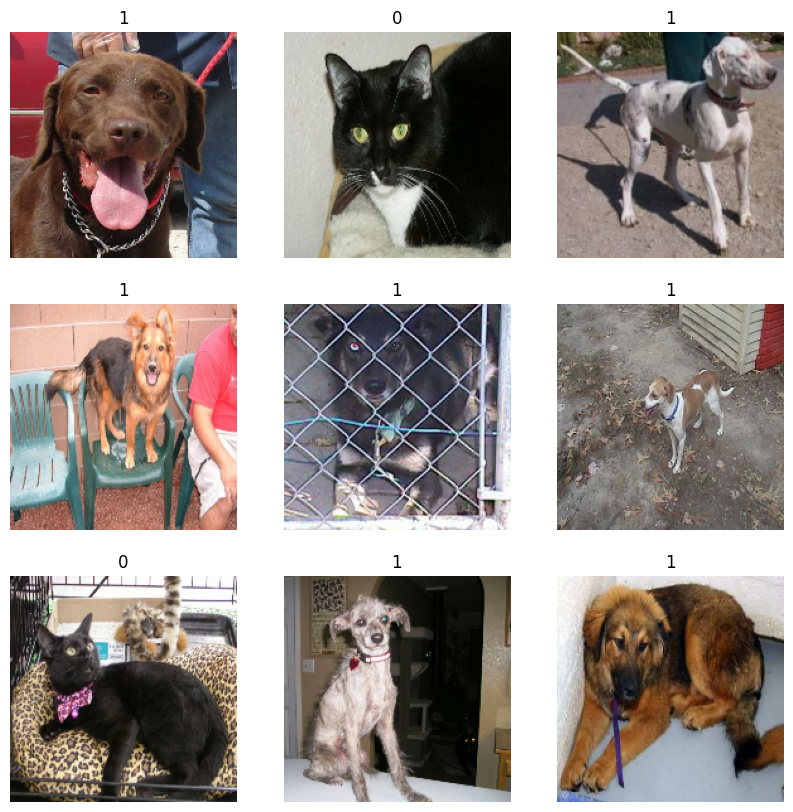

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")